In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
# plt.rcParams['lines.linewidth'] = 1.5
# plt.rcParams['font.size'] = 9
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = "dotted"
plt.rcParams["errorbar.capsize"] = 2
plt.rcParams["savefig.dpi"] = 200
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.01
# plt.rcParams["savefig.savefig.format"] = "svg"

from uncertainties import ufloat
from uncertainties.unumpy import uarray
from uncertainties.unumpy import nominal_values as unominal
from uncertainties.unumpy import std_devs as ustdev
from uncertainties import unumpy as unp

import pint
ureg = pint.UnitRegistry()

def ufloat_to_latex(uf, filename, var=None, dim=None, folder='tables'):
    res = ''
    if var is not None:
        res += var + '='
    res += f"{uf:L}"
    if dim is not None:
        res += ' \\ ' + dim
    filename = filename.replace('{', '')
    filename = filename.replace('}', '')
    with open(folder + '/' + filename, 'w') as f:
        print(res, file=f)

/var/folders/b0/r7cwq3l97dz61k8mlk7tswlc0000gn/T/ipykernel_11277/3993577176.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
R = ufloat(8.314, 0.001)
M = ufloat(46.1, 0.1)

ufloat_to_latex(R, 'R.tex', 'R', 'Дж/(моль \cdot K)')
ufloat_to_latex(M, 'M.tex', 'M', 'г/моль')

1. Измерьте разность уровней в ртутном U-образном манометре с помощью микроскопа и температуру по термометру или индикаторному табло.

In [3]:
dT = 0.1
T0 = 273.16

dP = 0.1

2. Включите термостат. Если вы работаете со схемой рис. 1, то подогревайте воду в калориметре, пропуская ток через нагреватель. Следите за тем, чтобы воздух всё время перемешивал воду.

    При работе как со схемой рис. 1, так и со схемой рис. 2, через каждый градус измеряйте давление и температуру.

    Продолжайте повышать температуру в течение половины имеющегося у вас времени, чтобы успеть произвести измерения при остывании прибора. Желательно нагреть жидкость до 40-50 °С.


3. Проведите те же измерения при охлаждении жидкости. Установите такой поток воды, чтобы охлаждение шло примерно тем же темпом, что и нагревание.


In [4]:
df_real = pd.read_csv('data/real.csv')[0:]
df_real['T'] = df_real['t'] + T0
df_real

,t,P,T
0,0,12.2,273.16
1,5,17.3,278.16
2,10,23.6,283.16
3,15,32.2,288.16
4,20,43.9,293.16
5,25,59.0,298.16
6,30,78.8,303.16
7,35,103.7,308.16
8,40,135.3,313.16


In [5]:
df_raw = pd.read_csv('data/data.csv')
df_raw['T'] = df_raw['t'] + T0

In [6]:
df_heat = df_raw[df_raw['heat'] == 1]
df_heat

,t,P,heat,T
0,23.15,46.49,1,296.31
1,25.26,53.58,1,298.42
2,27.30,59.79,1,300.46
3,29.24,66.75,1,302.40
4,31.24,75.64,1,304.40
5,33.23,84.59,1,306.39
6,35.22,94.01,1,308.38
7,37.19,105.04,1,310.35
8,39.16,116.51,1,312.32


In [7]:
df_cold = df_raw[df_raw['heat'] == 0]
df_cold

,t,P,heat,T
9,37.00,101.24,0,310.16
10,35.01,91.06,0,308.17
11,33.01,82.13,0,306.17
12,31.00,73.74,0,304.16
13,29.01,64.97,0,302.17
14,26.96,58.88,0,300.12


In [8]:
header = [r'$t$, $^\circ C$', r'$P$, $мм. рт. ст.$']
df_real.to_latex(buf=f"tables/real.tex", index=False, float_format="%.2f", columns=['t', 'P'], header=header, column_format='c|c')
df_heat.to_latex(buf=f"tables/heat.tex", index=False, float_format="%.2f", columns=['t', 'P'], header=header, column_format='c|c')
df_cold.to_latex(buf=f"tables/cold.tex", index=False, float_format="%.2f", columns=['t', 'P'], header=header, column_format='c|c')

4. Постройте графики в координатах $T$, $P$ и в координатах $1/T$, $\ln{P}$. На графики нанесите точки, полученные при нагревании и охлаждении жидкости (разными цветами).

    По формуле (1) вычислите $L$, пользуясь данными, полученными сначала из одного, а потом из другого графика. Находятся ли результаты в согласии друг с другом? Оцените ошибку измерений. Какой из графиков позволяет найти $L$ с лучшей точностью?


$$L = \frac{RT^2}{\mu P}\frac{dP}{dT} = - \frac{R}{\mu} \frac{d(ln P)}{d(1/T)}$$

950+/-29
925+/-32
935+/-13


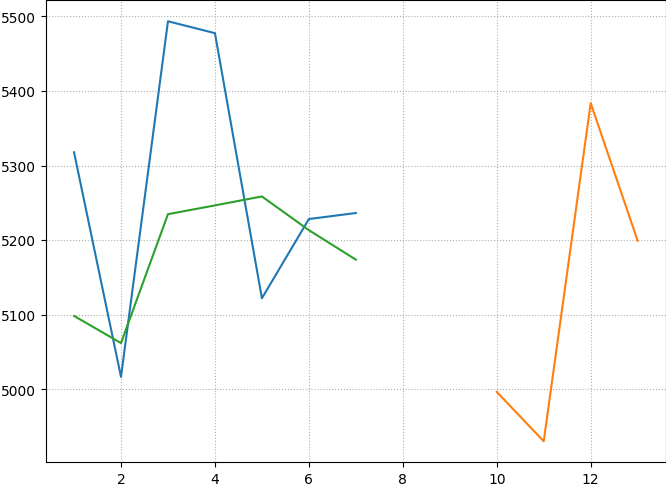

In [9]:
def handle(data, idx=None):
    L_data = data['T'] ** 2 / data['P'] * np.gradient(data['P'], data['T'])
    L_data = L_data[1:len(L_data) - 1]
    plt.plot(L_data)
    L = ufloat(np.mean(L_data), np.std(L_data)) * R / M
    print(L)
    if idx is not None:
        ufloat_to_latex(L, f'L{idx}.tex', f'L{idx}', 'Дж/г')

handle(df_heat, idx="^1_{нагр}")
handle(df_cold)
handle(df_real, idx="^1_{табл}")

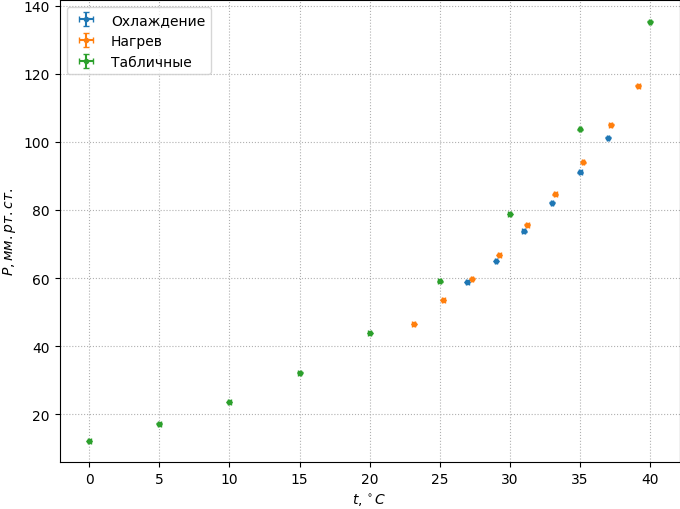

In [10]:
plt.xlabel(r"$t, ^\circ C$")
plt.ylabel(r"$P, мм. рт. ст.$")

def handle(data, label):
    plt.errorbar(data['t'], data['P'], xerr=dT, yerr=dP, fmt='.', label=label)

handle(df_cold, "Охлаждение")
handle(df_heat, "Нагрев")
handle(df_real, "Табличные")

plt.legend()
plt.savefig('images/P(t)')

- - Нагрев - -
5272+/-29
951+/-6
- - Табличные - -
5159+/-9
930.4+/-2.6


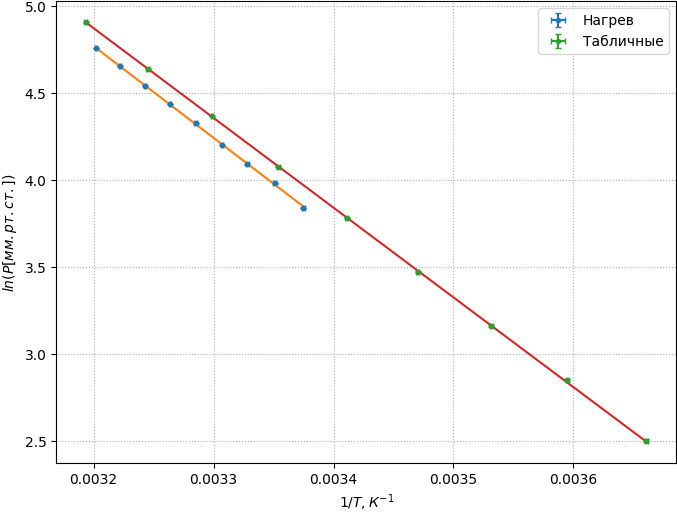

In [11]:
plt.xlabel(r"$1/T, К^{-1}$")
plt.ylabel(r"$ln(P[мм. рт. ст.])$")

def handle(data, label, idx=None):
    X = 1 / (data['T'].to_numpy())  # TODO
    Y = np.log(data['P'].to_numpy())
    dX = X * X * dT  # TODO
    dY = dP / data['P'].to_numpy()

    plt.errorbar(X, Y, xerr=dX, yerr=dY, fmt='.', label=label)

    func = lambda x, a, b: a * x + b
    popt, pcov = curve_fit(func, X, Y, sigma=dY)
    perr = np.sqrt(np.diag(pcov))

    a = -ufloat(popt[0], perr[0])
    L = R / M * a

    print(f'- - {label} - -')
    print(a)
    print(L)
    if idx is not None:
        ufloat_to_latex(L, f'L{idx}.tex', f'L{idx}', 'Дж/г')

    plt.plot(X, func(X, *popt))

handle(df_heat, "Нагрев", idx="^2_{нагр}")
# handle(data_cold, "Охлаждение")
handle(df_real, "Табличные", idx="^2_{табл}")

plt.legend()
plt.savefig('images/lnP(T^-1)')